**Imports**

In [ ]:
import pathlib
import numpy as np
import tensorflow as tf
import keras
from keras import *
from tensorflow.keras.optimizers import Adam
from keras.layers import *
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Load the dataset**

In [ ]:
def load_data():
  dataset_dir=pathlib.Path('drive/MyDrive/ML/HW3/Dataset_RX')

  img_height=200
  img_width=200
  batch_size=32

  datagen = ImageDataGenerator(
      rescale = 1. / 255,\
      rotation_range=10,\
      horizontal_flip=True,\
      vertical_flip=False)

  img_generator = datagen.flow_from_directory(
      directory=dataset_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      shuffle=True,
  )

  X_arr=[]
  i=0
  img=img_generator.next()
  while(i < img_generator.n):
    for j in range(0,32):
      if(i+j < img_generator.n):
        X_arr.append(img[0][j])
        i=i+1

  X_train = np.asarray(X_arr)
  return X_train


X_train=load_data()

Found 1583 images belonging to 1 classes.


**Visualize examples**

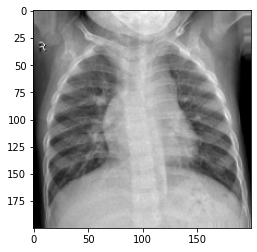

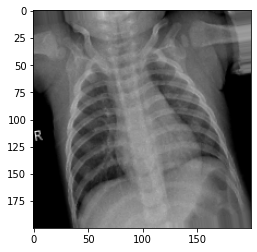

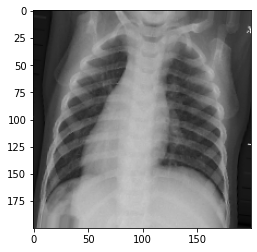

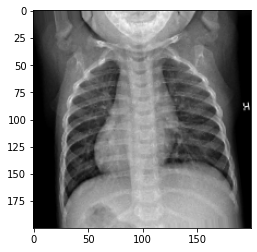

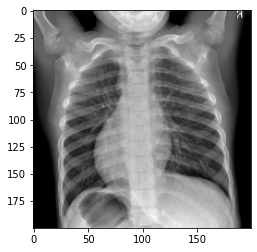

In [ ]:
n = 5

for i in range(0,n):
    image = X_train[i]
    plt.imshow(image)
    plt.show()

**Define the GAN model**

In [ ]:
class GAN():
 
    def __init__(self, latent_dim=128):

        self.img_rows = 200
        self.img_cols = 200
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
 
        optimizer = Adam(lr=0.0002, beta_1=0.5)
 
        disc_fn = self.build_discriminator
        gen_fn = self.build_generator

        # Build and compile the discriminator
        self.discriminator = disc_fn()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer, metrics=['accuracy'])

        # Latent space dimension for generator
        self.latent_dim = latent_dim

        # Output layer for generator (sigmoid or tanh)
        self.Goutact = 'sigmoid'   # 'tanh' does not work with CNN ???

        # Build and compile the generator
        self.generator = gen_fn()
        #self.generator.compile(loss='mse', optimizer=optimizer)
  
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
 
        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        self.combined.summary()
 
        # plot the models
        plot_model(self.discriminator, to_file='drive/MyDrive/ML/HW3/plots/2/D.png', show_shapes=True, show_layer_names=True)
        plot_model(self.generator, to_file='drive/MyDrive/ML/HW3/plots/2/G.png', show_shapes=True, show_layer_names=True)
        plot_model(self.combined, to_file='drive/MyDrive/ML/HW3/plots/2/GAN.png', show_shapes=True, show_layer_names=True)

        # Load the dataset
        self.X_train = load_data()
        
        #print(self.X_train.shape)
        #self.X_train = np.expand_dims(self.X_train, axis=3)
        #print(self.X_train.shape)

        # Training epochs
        self.epoch = 0


    def build_generator(self):

        noise_shape = (self.latent_dim,)
 
        model = Sequential()
 
        #model.add(Dense(256, input_shape=noise_shape))
        model.add(Dense(512, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(512))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(1024))
        model.add(Dense(2048))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation=self.Goutact))
        model.add(Reshape(self.img_shape))

        model.summary()

        return model


    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
 
        model = Sequential()
 
        model.add(Flatten(input_shape=img_shape))
        #model.add(Dense(512))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dense(256))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()

        return model


    def train(self, epochs, batch_size=128, save_interval=100, show_img=False):

        half_batch = int(batch_size / 2)
 
        last_epoch = self.epoch + epochs

        self.save_imgs(self.epoch)
        self.d_loss = []
        self.g_loss = []

        while self.epoch < last_epoch:
 
            # ---------------------
            #  Train Discriminator
            # ---------------------
 
            # Select a random half batch of images from dataset (real = 1)
            idx = np.random.randint(0, self.X_train.shape[0], half_batch)
            imgs = self.X_train[idx]
            y_imgs = np.ones((half_batch, 1))
 
            # Generate a half batch of images (fake = 0)
            noise = np.random.uniform(-1.0, 1.0, (half_batch, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            y_gen = np.zeros((half_batch, 1))
 
            # Train the discriminator
            X = np.vstack((imgs, gen_imgs))
            y = np.vstack((y_imgs, y_gen))
            d_loss = self.discriminator.train_on_batch(X, y)
            
            self.d_loss.append(d_loss[0])
 
            # ---------------------
            #  Train Generator
            # ---------------------
            noise = np.random.uniform(-1.0, 1.0, (batch_size, self.latent_dim))
 
            # The generator wants the discriminator to label the generated samples
            # as valid (real = 1)
            y_gennoise = np.ones((batch_size, 1))
 
            # Train the generator
            g_loss = self.combined.train_on_batch(noise, y_gennoise)
            self.g_loss.append(g_loss)
 
            self.epoch += 1

            # If at save interval => save generated image samples
            if self.epoch % save_interval == 0:
                # Plot the progress                
                print ( "%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (self.epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.save_imgs(self.epoch,show_img=False)
                if(str(self.epoch)[-3] == '5' or str(self.epoch - 500)[-3]=='5'):
                  self.save_imgs(self.epoch,show_img=True)
                  self.show_plot(self.epoch-500,self.epoch)
                


    def gen_imgs(self):
        cc = 9
        noise = np.random.uniform(-1.0, 1.0, (cc, self.latent_dim))
        self.imgs = self.generator.predict(noise)
 
        # Rescale images to [0,1]
        if self.Goutact=='tanh':
          self.imgs = 0.5 * self.imgs + 0.5


    def save_imgs(self, epoch, show_img=False):
        r, c = 3, 3
        self.gen_imgs()

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                self.img=self.imgs[cnt,:,:,:]
                self.img=np.reshape(self.img,[200,200,3])
                axs[i,j].imshow(self.img)
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("drive/MyDrive/ML/HW3/Generated_RX2/img_%05d.png" %(epoch))
        if show_img:
            plt.show()
        plt.close()


    def show_images(self):
        r, c = 3, 3
        self.gen_imgs()
 
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                self.img=self.imgs[cnt,:,:,:]
                self.img=np.reshape(self.img,[200,200,3])
                axs[i,j].imshow(self.img)
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()


    def save_model(self):
      filename = 'drive/MyDrive/ML/HW3/Models/RX2/G_model_%05d.h5' %(self.epoch)
      self.generator.save(filename)
      filename = 'drive/MyDrive/ML/HW3/Models/RX2/D_model_%05d.h5' %(self.epoch)
      self.discriminator.save(filename)
      print("Models G/%s saved." %(filename))

    def show_plot(self, start, end):
      plt.subplots()
      plt.xlim(start,end)
      plt.plot(self.d_loss, label='D loss')
      plt.plot(self.g_loss, label='G loss')
      plt.show()
      plt.close()

    def load_model(self,epoch):
      optimizer = Adam(lr=0.0002, beta_1=0.5)
      self.epoch = epoch
      filename = 'G_model_%05d.h5' %(self.epoch)
      self.generator= tf.keras.models.load_model(filename)
      filename = 'D_model_%05d.h5' %(self.epoch)
      self.discriminator= tf.keras.models.load_model(filename)
      self.discriminator.trainable = False

      self.combined = Sequential()
      self.combined.add(self.generator)
      self.combined.add(self.discriminator)
      self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
      print("Models G/%s loaded." %(filename))

**Create the GAN**

In [ ]:
gan = GAN(latent_dim=256)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 120000)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              122881024 
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)              

**train and save the GAN**

100 [D loss: 0.947219, acc.: 90.62%] [G loss: 17.995493]
200 [D loss: 2.493396, acc.: 56.25%] [G loss: 6.427276]
300 [D loss: 2.010633, acc.: 50.00%] [G loss: 0.648027]
400 [D loss: 1.055534, acc.: 50.00%] [G loss: 3.307745]
500 [D loss: 0.500393, acc.: 68.75%] [G loss: 2.880703]


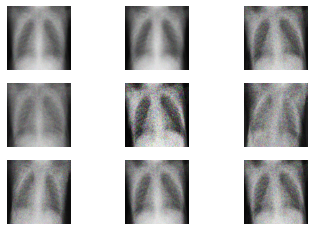

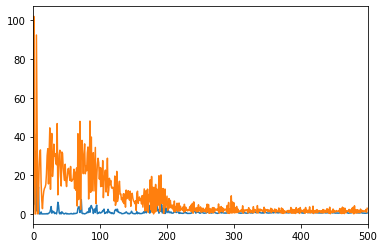

600 [D loss: 0.450753, acc.: 90.62%] [G loss: 1.571127]
700 [D loss: 0.511902, acc.: 75.00%] [G loss: 1.595235]
800 [D loss: 0.536252, acc.: 68.75%] [G loss: 1.233167]
900 [D loss: 0.513924, acc.: 68.75%] [G loss: 1.757797]
1000 [D loss: 0.723868, acc.: 53.12%] [G loss: 0.926992]


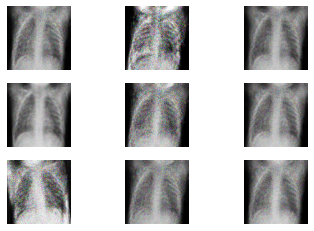

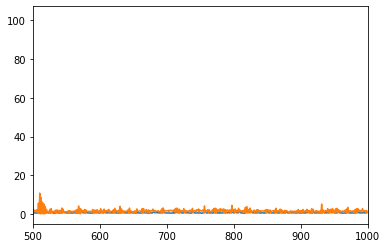

1100 [D loss: 0.563060, acc.: 62.50%] [G loss: 1.985876]
1200 [D loss: 0.543401, acc.: 68.75%] [G loss: 1.988326]
1300 [D loss: 0.442332, acc.: 78.12%] [G loss: 2.008199]
1400 [D loss: 0.358545, acc.: 81.25%] [G loss: 1.700450]
1500 [D loss: 0.350185, acc.: 84.38%] [G loss: 1.245745]


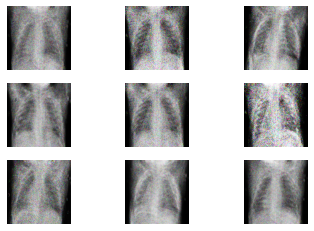

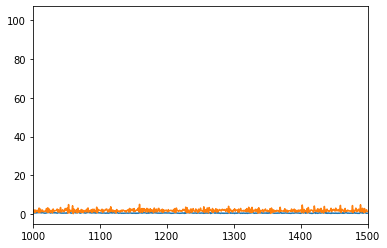

1600 [D loss: 0.432508, acc.: 78.12%] [G loss: 1.818657]
1700 [D loss: 0.621153, acc.: 68.75%] [G loss: 1.364106]
1800 [D loss: 0.466021, acc.: 71.88%] [G loss: 4.084167]
1900 [D loss: 0.335336, acc.: 84.38%] [G loss: 2.791069]
2000 [D loss: 0.300615, acc.: 96.88%] [G loss: 2.069652]


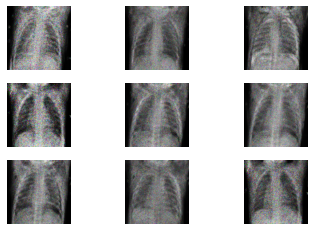

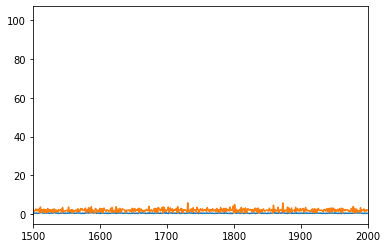

2100 [D loss: 0.303136, acc.: 96.88%] [G loss: 1.761859]
2200 [D loss: 17.755722, acc.: 50.00%] [G loss: 19.273155]
2300 [D loss: 0.472837, acc.: 75.00%] [G loss: 0.477282]
2400 [D loss: 0.329533, acc.: 87.50%] [G loss: 1.679626]
2500 [D loss: 0.266250, acc.: 93.75%] [G loss: 1.962136]


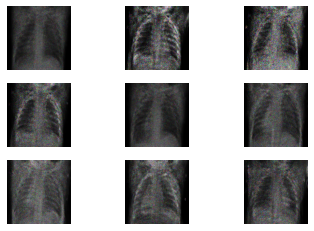

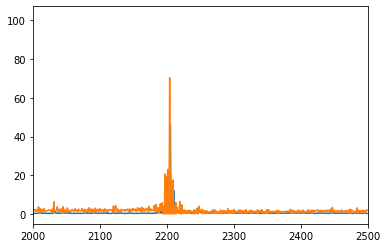

2600 [D loss: 0.377233, acc.: 81.25%] [G loss: 1.471466]
2700 [D loss: 0.335036, acc.: 90.62%] [G loss: 1.255611]
2800 [D loss: 0.305717, acc.: 90.62%] [G loss: 1.843837]
2900 [D loss: 0.411546, acc.: 84.38%] [G loss: 0.882250]
3000 [D loss: 0.275100, acc.: 93.75%] [G loss: 1.484167]


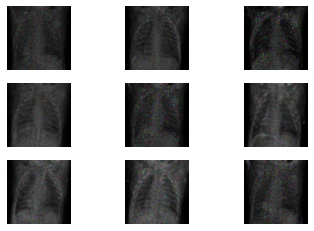

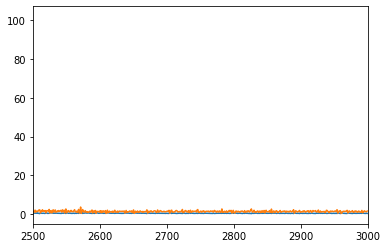

3100 [D loss: 0.393480, acc.: 84.38%] [G loss: 1.321649]
3200 [D loss: 0.283624, acc.: 96.88%] [G loss: 1.832631]
3300 [D loss: 0.278425, acc.: 84.38%] [G loss: 1.825284]
3400 [D loss: 0.178556, acc.: 100.00%] [G loss: 2.008525]
3500 [D loss: 0.241418, acc.: 96.88%] [G loss: 1.425415]


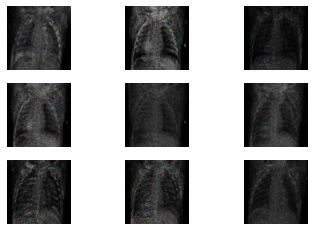

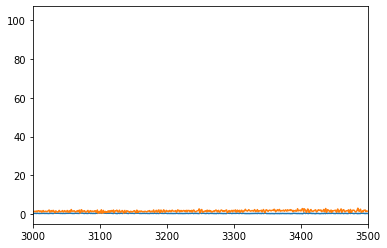

3600 [D loss: 0.245775, acc.: 93.75%] [G loss: 1.526634]
3700 [D loss: 0.166566, acc.: 100.00%] [G loss: 1.488524]
3800 [D loss: 0.184877, acc.: 100.00%] [G loss: 1.520028]
3900 [D loss: 0.100649, acc.: 96.88%] [G loss: 2.893513]
4000 [D loss: 0.243710, acc.: 87.50%] [G loss: 2.076467]


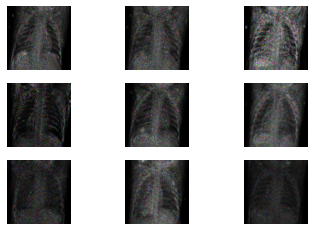

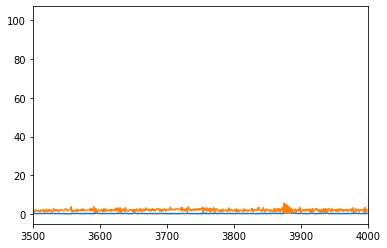

4100 [D loss: 0.146291, acc.: 100.00%] [G loss: 3.242584]
4200 [D loss: 0.118498, acc.: 96.88%] [G loss: 2.936981]
4300 [D loss: 0.131557, acc.: 100.00%] [G loss: 1.685134]
4400 [D loss: 0.177046, acc.: 96.88%] [G loss: 2.512712]
4500 [D loss: 0.149923, acc.: 96.88%] [G loss: 2.347956]


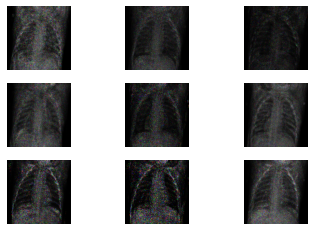

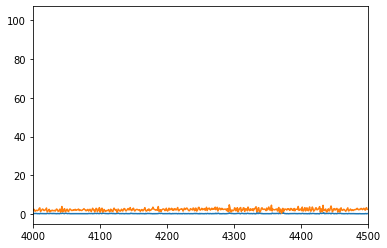

4600 [D loss: 0.191566, acc.: 93.75%] [G loss: 1.986596]
4700 [D loss: 0.173494, acc.: 93.75%] [G loss: 2.054920]
4800 [D loss: 0.070871, acc.: 100.00%] [G loss: 3.376867]
4900 [D loss: 0.048557, acc.: 100.00%] [G loss: 2.469105]
5000 [D loss: 0.144913, acc.: 93.75%] [G loss: 2.208153]


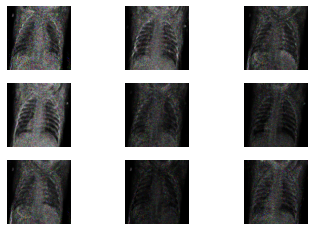

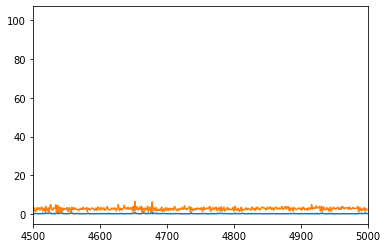

5100 [D loss: 0.290685, acc.: 93.75%] [G loss: 3.287498]
5200 [D loss: 0.162505, acc.: 93.75%] [G loss: 2.356327]
5300 [D loss: 0.056226, acc.: 100.00%] [G loss: 3.233842]
5400 [D loss: 0.037450, acc.: 100.00%] [G loss: 4.518679]
5500 [D loss: 0.092763, acc.: 96.88%] [G loss: 3.447011]


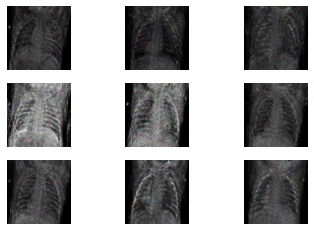

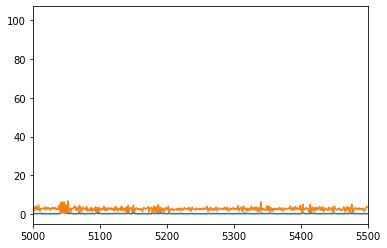

5600 [D loss: 0.116777, acc.: 100.00%] [G loss: 3.269394]
5700 [D loss: 0.994567, acc.: 50.00%] [G loss: 1.023202]
5800 [D loss: 0.291341, acc.: 90.62%] [G loss: 0.312254]
5900 [D loss: 0.189160, acc.: 93.75%] [G loss: 1.814241]
6000 [D loss: 0.385466, acc.: 81.25%] [G loss: 1.656984]


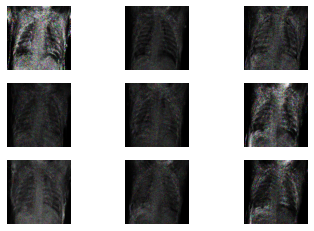

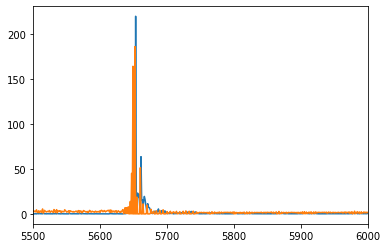

6100 [D loss: 0.129178, acc.: 100.00%] [G loss: 1.426490]
6200 [D loss: 0.257823, acc.: 90.62%] [G loss: 1.285261]
6300 [D loss: 0.393827, acc.: 78.12%] [G loss: 0.962913]
6400 [D loss: 4.134310, acc.: 53.12%] [G loss: 0.050787]
6500 [D loss: 0.299035, acc.: 90.62%] [G loss: 0.749604]


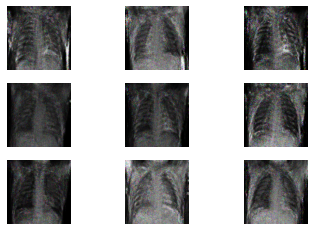

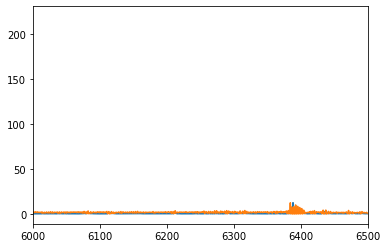

6600 [D loss: 0.642165, acc.: 75.00%] [G loss: 2.772188]
6700 [D loss: 0.197533, acc.: 96.88%] [G loss: 2.276494]
6800 [D loss: 0.190589, acc.: 100.00%] [G loss: 1.438444]
6900 [D loss: 0.532496, acc.: 71.88%] [G loss: 3.252024]
7000 [D loss: 0.259228, acc.: 87.50%] [G loss: 2.577168]


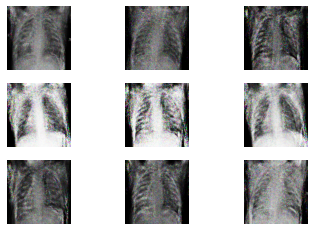

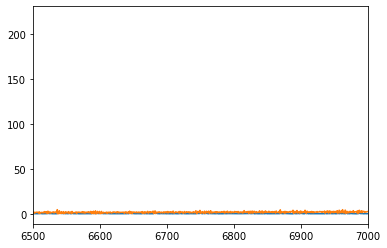

7100 [D loss: 0.273538, acc.: 93.75%] [G loss: 3.368411]
7200 [D loss: 0.343071, acc.: 87.50%] [G loss: 1.722727]
7300 [D loss: 0.306421, acc.: 96.88%] [G loss: 2.404443]
7400 [D loss: 0.247099, acc.: 84.38%] [G loss: 2.482025]
7500 [D loss: 0.325273, acc.: 78.12%] [G loss: 1.970106]


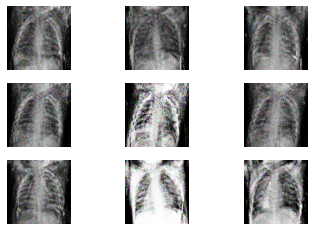

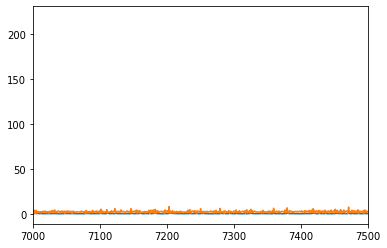

7600 [D loss: 0.748278, acc.: 65.62%] [G loss: 0.895661]
7700 [D loss: 0.324935, acc.: 75.00%] [G loss: 1.011993]
7800 [D loss: 0.596431, acc.: 68.75%] [G loss: 1.266647]
7900 [D loss: 0.495138, acc.: 71.88%] [G loss: 0.923708]
8000 [D loss: 0.230638, acc.: 90.62%] [G loss: 1.948961]


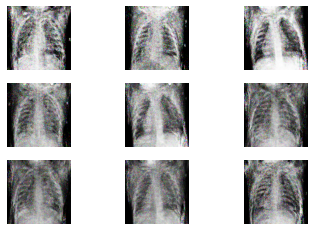

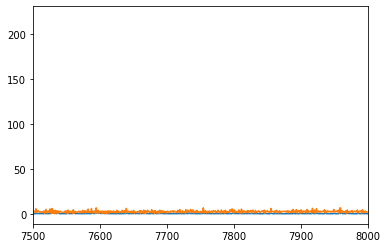

8100 [D loss: 0.322194, acc.: 84.38%] [G loss: 1.716190]
8200 [D loss: 0.307054, acc.: 81.25%] [G loss: 1.123918]
8300 [D loss: 0.104508, acc.: 100.00%] [G loss: 2.985170]
8400 [D loss: 0.602482, acc.: 75.00%] [G loss: 0.965219]
8500 [D loss: 0.096140, acc.: 100.00%] [G loss: 3.706502]


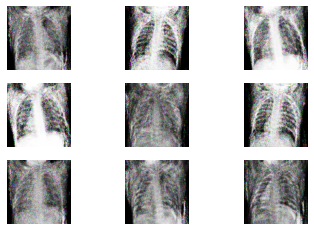

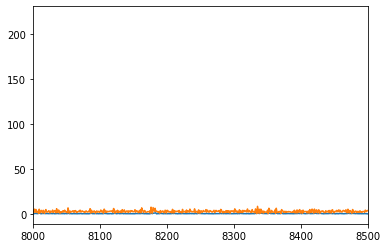

8600 [D loss: 0.691309, acc.: 68.75%] [G loss: 5.241611]
8700 [D loss: 0.292277, acc.: 87.50%] [G loss: 1.736704]
8800 [D loss: 0.193204, acc.: 90.62%] [G loss: 2.259970]
8900 [D loss: 0.414895, acc.: 75.00%] [G loss: 1.710186]
9000 [D loss: 0.953856, acc.: 71.88%] [G loss: 2.913363]


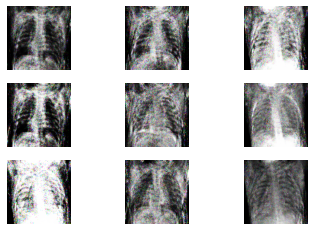

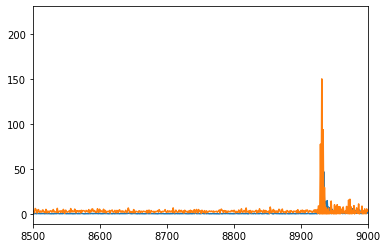

9100 [D loss: 1.577342, acc.: 50.00%] [G loss: 4.673008]
9200 [D loss: 0.801538, acc.: 84.38%] [G loss: 2.919546]
9300 [D loss: 0.721353, acc.: 84.38%] [G loss: 3.101167]
9400 [D loss: 0.434590, acc.: 68.75%] [G loss: 0.908997]
9500 [D loss: 0.170018, acc.: 100.00%] [G loss: 3.957152]


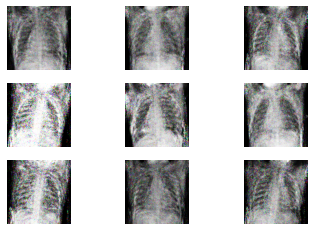

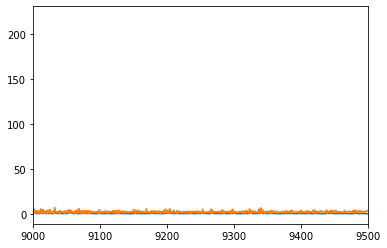

9600 [D loss: 0.587245, acc.: 78.12%] [G loss: 1.441858]
9700 [D loss: 0.492008, acc.: 84.38%] [G loss: 4.619634]
9800 [D loss: 0.313204, acc.: 81.25%] [G loss: 2.013073]
9900 [D loss: 0.411733, acc.: 75.00%] [G loss: 1.413869]
10000 [D loss: 0.307115, acc.: 84.38%] [G loss: 2.417282]


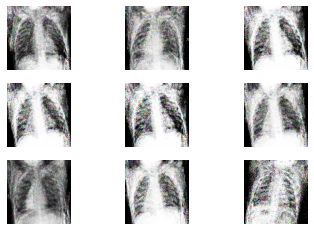

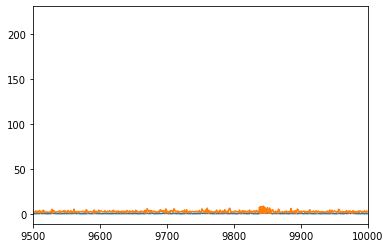

Models G/drive/MyDrive/ML/HW3/Models/RX2/D_model_10000.h5 saved.


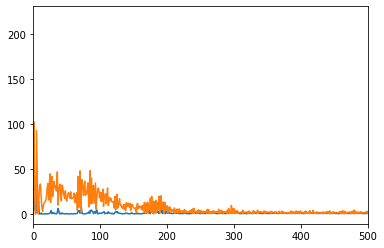

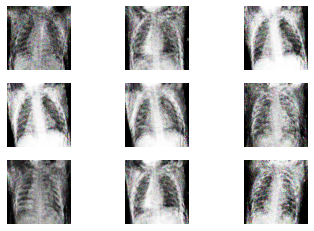

In [ ]:
gan.train(epochs=10000, batch_size=32, save_interval=100)
gan.save_model()
plt.subplots()
plt.xlim(0,500)
plt.plot(gan.d_loss, label='D loss')
plt.plot(gan.g_loss, label='G loss')
plt.show()
plt.close()
gan.show_images()

**Plot losses**

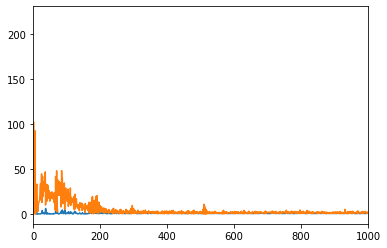

In [ ]:
plt.subplots()
plt.xlim(0,1000)
plt.plot(gan.d_loss, label='D loss')
plt.plot(gan.g_loss, label='G loss')
plt.show()
plt.close()

**Show examples of the generated images**

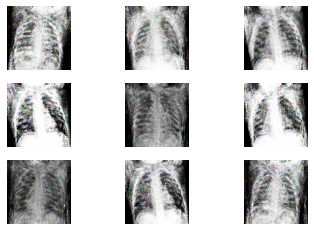

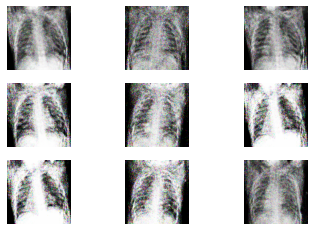

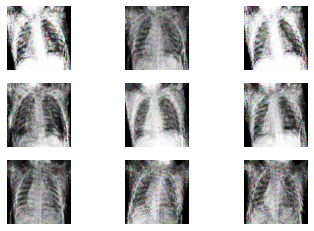

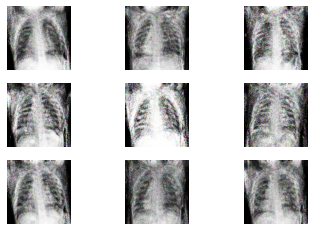

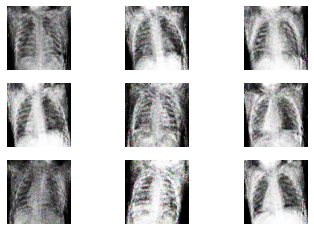

In [ ]:
i=0
while(i<5):
  gan.show_images()
  i=i+1

**Save the model**

In [ ]:
gan.save_model()

Models G/drive/MyDrive/ML/HW3/Models/RX2/D_model_10000.h5 saved.
